# Automatic grain detection

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import segment_anything
import segmenteverygrain
import segmenteverygrain.interactions as si
from tqdm import tqdm

# Display plots in notebook
%matplotlib inline

2025-06-01 16:14:41.103539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748819681.115574   40765 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748819681.119146   40765 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-01 16:14:41.130980: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load image

Images can be loaded in most common formats. Avoid lossy compression for best results.

In [2]:
fn = 'examples/torrey_pines.jpg'
image = si.load_image(fn)

### Prompt generation
A U-Net neural network performs a "first pass" of the image to quickly generate a list of points where grains may be. It may be possible to tweak `I` and `dbs_max_dist` for better results.

In [3]:
# Load U-Net model
fn = './segmenteverygrain/seg_model.keras'
unet = keras.saving.load_model(fn, custom_objects={
    'weighted_crossentropy': segmenteverygrain.weighted_crossentropy})

2025-06-01 16:14:45.842019: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
# Generate prompts with U-Net model
unet_image = segmenteverygrain.predict_image(image, unet, I=256)
unet_labels, unet_coords = segmenteverygrain.label_grains(
    image, unet_image, dbs_max_dist=20.)

segmenting image tiles...


100%|██████████| 6/6 [00:01<00:00,  3.18it/s]


If the U-Net model is trained appropriately for the given image, the diagnostic image below should be a fairly clean representation of grains (green) and background (red), with each grain having only a few prompts (black dots) on it. If results are poor, the U-Net model can be retrained using a different script.

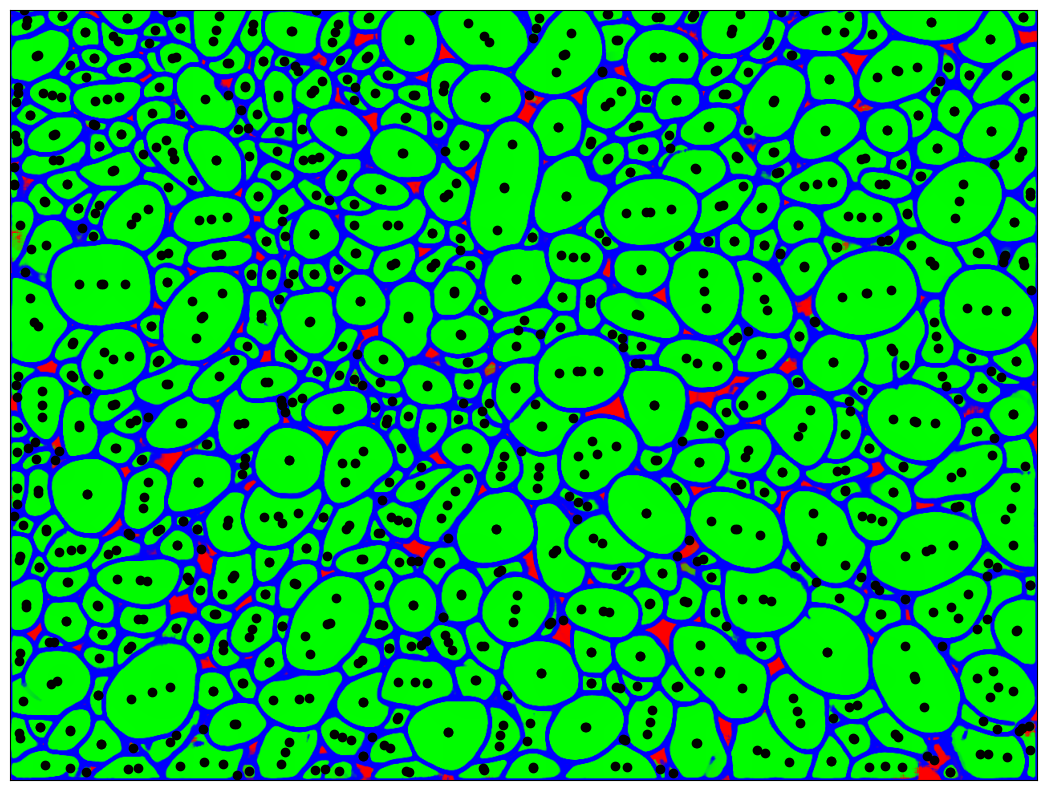

In [5]:
# Generate U-Net diagnostic image
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(unet_image)
plt.scatter(np.array(unet_coords)[:,0], np.array(unet_coords)[:,1], c='k')
plt.xticks([])
plt.yticks([]);

In [6]:
# Save diagnostic image
out_fn = 'examples/auto/torrey_pines'
fig.savefig(out_fn + '_unet.jpg', bbox_inches='tight', pad_inches=0)
plt.close()

### Grain segmentation
The Segment Anything Model (SAM) attempts to investigate each prompt generated by the U-Net model, outlining the "segment" of the image representing each grain. Resulting polygons are then cleaned up to avoid duplicates and find the best fit for each grain.

Loading the SAM should take less than a minute. Running it can take a very long time depending on computing resources, image size, and the quality of U-Net results.

SAM checkpoints can be downloaded [here](https://huggingface.co/ybelkada/segment-anything/blob/main/checkpoints/sam_vit_h_4b8939.pth).

In [7]:
# Load SAM
fn = 'sam_vit_h_4b8939.pth'
sam = segment_anything.sam_model_registry['default'](checkpoint=fn)
predictor = segment_anything.SamPredictor(sam)
predictor.set_image(image)

Verify that `min_area` is reasonable as a lower bound for the pixel area of detected grains.

`plot_image` will produce a colorful representation of detected grains.

`remove_edge_grains` and `remove_large_objects` work as described, removing any grains that are likely to be cut off by image borders or large objects that may be accidentally detected as grains.

creating masks using SAM...


100%|██████████| 1041/1041 [01:01<00:00, 17.05it/s]


finding overlapping polygons...


872it [00:05, 168.45it/s]


finding best polygons...


100%|██████████| 333/333 [00:09<00:00, 35.52it/s]


creating labeled image...


100%|██████████| 408/408 [00:02<00:00, 161.19it/s]


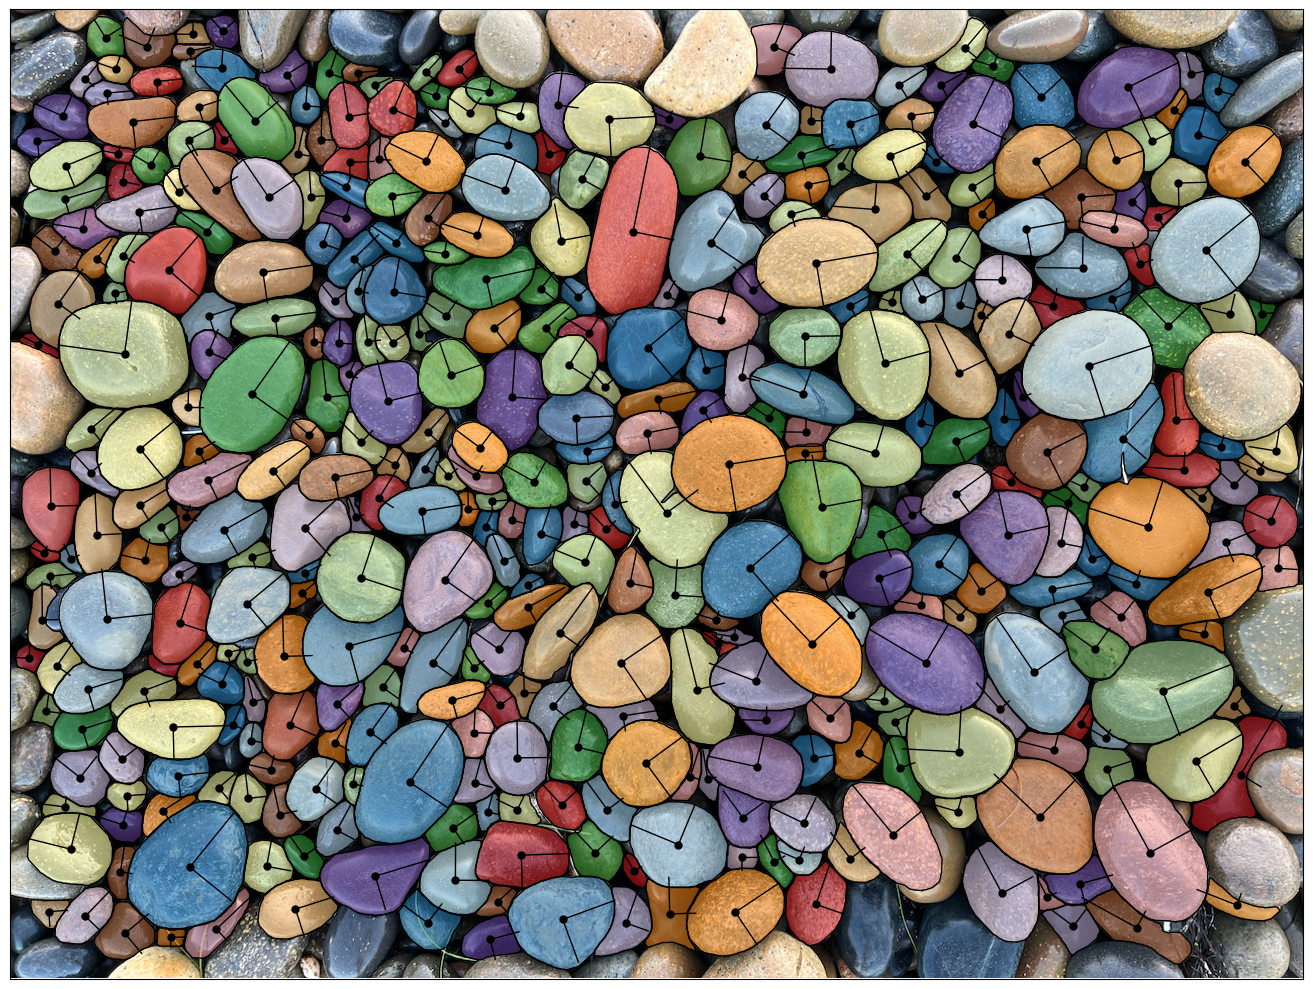

In [8]:
# Apply SAM for actual segmentation
polygons, sam_labels, mask, summary, fig, ax = segmenteverygrain.sam_segmentation(
    sam, image, unet_image, unet_coords, unet_labels,
    min_area=300,
    plot_image=True,
    remove_edge_grains=True,
    remove_large_objects=False)

In [9]:
# Save SAM image
out_fn = 'examples/auto/torrey_pines'
fig.savefig(out_fn + '_grains.jpg', bbox_inches='tight', pad_inches=0)
plt.close()

### Results

Polygons detected by the SAM are used to construct Grain objects, which provide methods for measuring and extracting data.

In [10]:
# Extract results
grains = si.polygons_to_grains(polygons, image=image)
for g in tqdm(grains, desc='Measuring detected grains'):
    g.measure()

Measuring detected grains: 100%|██████████| 408/408 [00:00<00:00, 1021.99it/s]


The following results are then saved to the location specified in `out_fn`:
- Grain shapes, for use elsewhere (geojson)
- Summary data, presenting measurements for each detected grain (csv)
- Summary histogram, representing major/minor axes of detected grains (jpg)
- Mask representations of the detected grains, in both computer-readable (png, 0-1) and human-readable (jpg, 0-255) formats

If `px_per_m` is 1, then the summary data and histogram will be in pixels. If the ratio of pixels to meters is known, set `px_per_m` in order to save them in meters.

In [11]:
# Save results
px_per_m = 3390.    # Arbitrary; change this if known!
out_fn = 'examples/auto/torrey_pines'
# Grain shapes
si.save_grains(out_fn + '_grains.geojson', grains)
# Summary data
summary = si.save_summary(out_fn + '_summary.csv', grains, px_per_m=px_per_m)
# Summary histogram
si.save_histogram(out_fn + '_summary.jpg', summary=summary)
# Training mask
si.save_mask(out_fn + '_mask.png', grains, image, scale=False)
si.save_mask(out_fn + '_mask2.jpg', grains, image, scale=True)